In [ ]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import matplotlib
import pystan 
import warnings
warnings.filterwarnings("ignore")

We will be working with 5 products. We are given embedding of size 5 for each product. 

In [ ]:
book, journal, rice, salad, beer = 0,1,2,3,4
name_map = {book: 'book', journal: 'journal', rice: 'rice', salad: 'salad', beer: 'beer'}

In [ ]:
product_embeddings = np.array([[1.,0.5,0,0,0], [.6,1,0,0,0], [0,0,1,.3,0], [0,0,0.1,1,0], [0,.0,0,0,1]])
num_products, dim = product_embeddings.shape
w1 = 1.
w2 = 1.

In [ ]:
P = 5 # number of products


log = [{'a': book, 'h': [book], 'I': 1000, 'C': 100},
        {'a': journal, 'h': [book], 'I': 1000, 'C': 20},
        {'a': rice, 'h': [book], 'I': 0, 'C': 0},        
        {'a': salad, 'h': [book], 'I': 0, 'C': 0},
        {'a': beer, 'h': [book], 'I': 0, 'C': 0},        
        {'a': book, 'h': [journal], 'I': 1000, 'C': 10},
        {'a': journal, 'h': [journal], 'I': 1000, 'C': 10},
        {'a': rice, 'h': [journal], 'I': 0, 'C': 0},                          
        {'a': salad, 'h': [journal], 'I': 0, 'C': 0},
        {'a': beer, 'h': [journal], 'I': 0, 'C': 0},
        {'a': book, 'h': [rice], 'I': 0, 'C': 0},
        {'a': journal, 'h': [rice], 'I': 0, 'C': 0},
        {'a': rice, 'h': [rice], 'I': 1000, 'C': 10},        
        {'a': salad, 'h': [rice], 'I': 1000, 'C': 20},
        {'a': beer, 'h': [rice], 'I': 0, 'C': 0},
        {'a': book, 'h': [salad], 'I': 0, 'C': 0},
        {'a': journal, 'h': [salad], 'I': 0, 'C': 0},
        {'a': rice, 'h': [salad], 'I': 1000, 'C': 20},        
        {'a': salad, 'h': [salad], 'I': 1000, 'C': 10},
        {'a': beer, 'h': [salad], 'I': 0, 'C': 0},
        {'a': book, 'h': [beer], 'I': 0, 'C': 0},
        {'a': journal, 'h': [beer], 'I': 0, 'C': 0},
        {'a': rice, 'h': [beer], 'I': 0, 'C': 0},        
        {'a': salad, 'h': [beer], 'I': 0, 'C': 0},
        {'a': beer, 'h': [beer], 'I': 1000, 'C': 20}]

In [ ]:
def expand_timelines(timeline, product_embeddings):
  num_clicks = timeline['C']
  num_impressions = timeline['I']
  action = timeline['a']
  history_embedding = np.vstack([product_embeddings[h,:] for h in timeline['h']]).mean(0)
  return history_embedding, action, num_clicks, num_impressions

def prepare_data(log, product_embeddings):
  data = np.vstack([np.hstack(expand_timelines(d, product_embeddings)) for d in log])
  user_embeddings = data[:, :dim]
  actions = np.array(data[:, dim], dtype=int)
  clicks = np.array(data[:, dim+1], dtype=int)
  impressions = np.array(data[:, dim+2], dtype=int)
  return user_embeddings, actions, clicks, impressions

def plot_hist(extract, key='ctr', plot_ctr=True):
    mean = extract[key].mean(0).flatten()
    low = mean - np.percentile(extract[key], 2.5,axis=0).flatten()
    up = np.percentile(extract[key], 97.5, axis=0).flatten() - mean


    xnames = ['-'.join(arg) for arg in product(*[name_map.values()]*len(extract[key].mean(0).shape))]

    plt.figure(figsize=(30, 8))

    plt.errorbar(xnames, y=mean.flatten(), yerr=np.vstack((low,up)), fmt='.',ecolor=''.join([c*5 for c in ['b', 'g', 'r', 'c', 'm', 'y', 'k']]))
    plt.plot(xnames, mean.flatten(),'go')
    plt.tick_params(axis='both', which='major', labelsize=15)
    _ = plt.xticks(rotation=90)

    if len(extract[key].mean(0).shape) == 2 and plot_ctr:
      plt.plot(xnames, (clicks)/(impressions), 'x', c='k')
    plt.show()
    
def print_best_rec():
    best_rec = extract['ctr'].mean(0).argmax(1)

    for i in range(num_products):
        print('when hist is ' + list(name_map.values())[i] + ', recommend ' + list(name_map.values())[best_rec[i]])

In [ ]:
script = """
data {
  int N;
  int num_products;
  int dim;

  int clicks[N];
  int impressions[N];  
  int actions[N];

  matrix[N, dim] user_embeddings;
  matrix[num_products, dim] product_embeddings;

  real w1;
  real w2;
}

parameters {
  matrix[dim, dim] eps;
  real offset;
  real rho[num_products];
} 

transformed parameters{
  matrix[num_products, dim] beta;

  beta = w1 * product_embeddings + w2 * product_embeddings * eps;
}

model {
  rho ~ normal(0, 0.1);
  offset ~ normal(-8,2);
  for (k in 1:dim) {
    eps[k] ~ normal(0, 1);
  }

  for (n in 1:N) {
    clicks[n] ~ binomial_logit(impressions[n],  dot_product(user_embeddings[n], 
                              beta[actions[n],:]) + offset + rho[actions[n]]);
  }
}

generated quantities {
  matrix[num_products,num_products] ctr;
  real ctr2[num_products,num_products,num_products];
  real ctr_for_users[N];

  for (n in 1:N) {
    ctr_for_users[n] = inv_logit(dot_product(user_embeddings[n], beta[actions[n],:]) + offset + rho[actions[n]]);
  }

  for (h in 1:num_products) {
    for (action in 1:num_products) {
      ctr[h, action] = inv_logit(dot_product(product_embeddings[h, :], beta[action,:]) + offset + rho[action]);
    }
  }
  
  for (h1 in 1:num_products) {
    for (h2 in 1:num_products) {
      for (action in 1:num_products) {
        ctr2[h1, h2, action] = inv_logit(dot_product((product_embeddings[h1, :]+product_embeddings[h2, :])/2, beta[action,:]) + offset + rho[action]);
      }
    }
  }
}
"""


model = pystan.StanModel(model_code=script)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c6084743d55de859e958234dd2abeed NOW.


Let's fit the model using the organic embeddings and the bandit data with Stan

In [ ]:
user_embeddings, actions, clicks, impressions = prepare_data(log, product_embeddings)

N = user_embeddings.shape[0] 

fit=model.sampling(data={'w1': w1, 'w2': w2, 'clicks': clicks, 'impressions': impressions,
                         'N': N, 'num_products': num_products, 'actions': actions+1,
                         'dim': dim, 'product_embeddings': product_embeddings, 
                         'user_embeddings': user_embeddings})
extract = fit.extract()

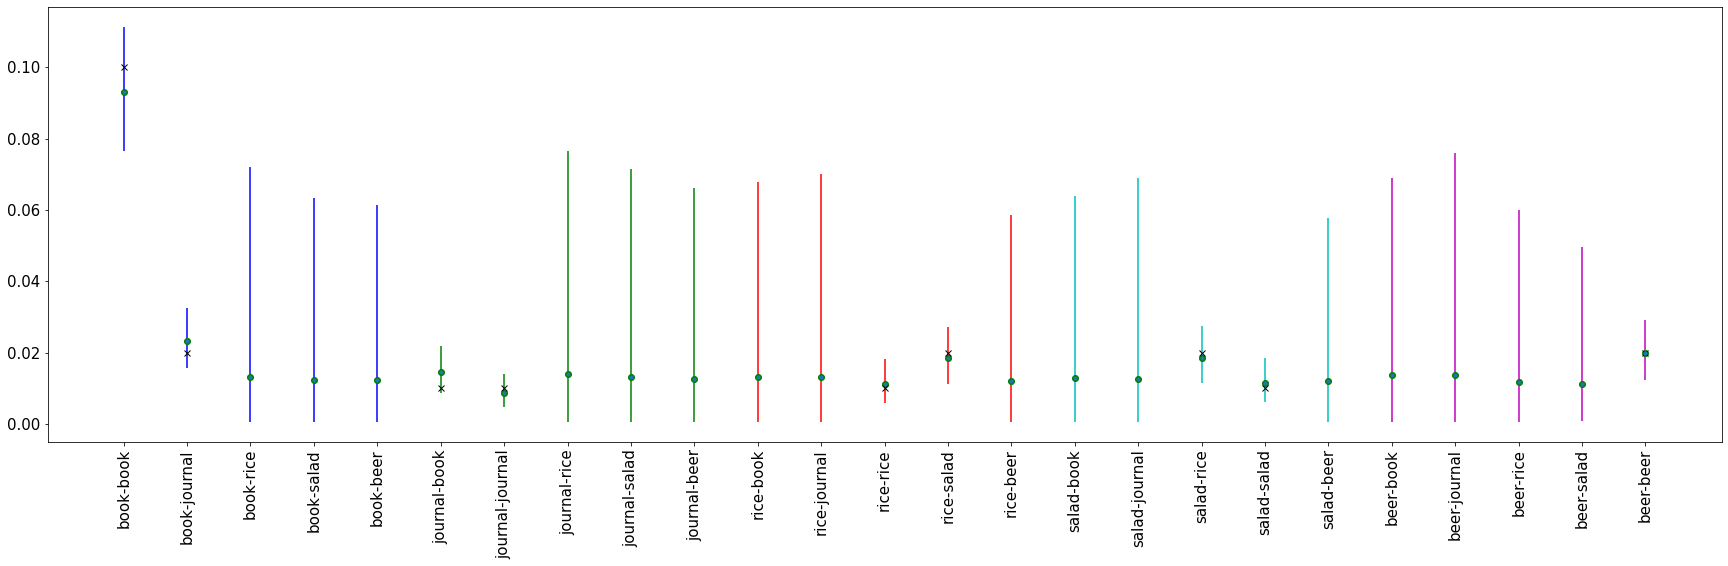

In [ ]:
plot_hist(extract, 'ctr', True)

In [ ]:
print_best_rec()

when hist is book, recommend book
when hist is journal, recommend book
when hist is rice, recommend salad
when hist is salad, recommend rice
when hist is beer, recommend beer


Exact sampling methods give near perfect results when the size of the dataset is small and the dimensionality of the problem is in the order of hundrers. In real life recommendation problem, these conditions are not met, we treat datasets of millions of records with a dimentionality that is at least linear on the number of products, meaning that these methods will suffer from very slow convergence time and we will need faster methods to infer our model's parameters.

In this tutorial, we're gonna use variational bayes, coupled with the reparametrization trick, to approximately infer the posterior over our models parameters, trading off accuracy for scalability.

Bayesian statistics & ML can be reduced to computing integrals over posteriors that are defined as :
$$P(\theta|D) \propto L(D|\theta) P(\theta) $$ 

with $L(D|\theta)$ the likelihood and $P(\theta)$ the prior over the parameters.

Variational Bayes leverage another definition of the posterior, in terms of minimizing the kullback-leibler divergence.

With $Q$ being the space of distributions that are absolutely continuous w.r.t the prior $P$, one can define the posterior by this trivial equation :

$$P(\theta|D) = \text{argmin}_{q \in Q} KL(q||P(\theta|D)) $$ 

which is equivalent to :

\begin{align}
P(\theta|D) &= \text{argmin}_{q \in Q} - E_q[\log L(D|\theta)] + KL(q||P(\theta)) \\
&= \text{argmin}_{q \in Q} - ELBO(q)
\end{align}

Meaning that minimizing the negative ELBO in the space of distributions will lead us to the true posterior. But for tractability, we always reduce the optimization space to a simpler parametric space where optimization is often tractable. We try to find a distribution $q_\lambda^*$ which can approximate the true posterior, in a parametrised space $Q(\lambda)$ which is for instance the family of multivariate gaussians in our case (parametrised by a mean and a covariance matrix).

Our problem becomes :

\begin{align}
q_\lambda^* = \text{argmin}_{q_\lambda \in Q(\lambda)} - ELBO(q_\lambda)
\end{align}

In [ ]:
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow==1.15.2

In [ ]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

tf.set_random_seed(42)

inv_softplus = lambda x : np.log(np.exp(x) - 1)

init_rho = inv_softplus(np.ones(P))[:,np.newaxis]

Our objective is to find the $\text{argmin}_{q_\lambda \in Q(\lambda)} - E_{q_\lambda}[\log L(D|\theta)] + KL(q_\lambda||P(\theta))$. In our problem, $Q(\lambda)$ is the family of factorized multivariate gaussians, with mean $\mu$ and covariance $\text{diag}(\sigma^2)$. As we used gaussian priors in the definition of our model, we can leverage a closed form of the KL term found in the negative $ELBO$ :

$$KL(\mathcal{N}(\mu, \sigma^2)|\mathcal{N}(\mu_0, \sigma_0^2)) = \frac{1}{2}\sum_{i=1}^d [2\log \frac{\sigma_0{_i}}{\sigma_i} - d + \frac{\sigma_i^2 + (\mu_i - \mu_0{_i})^2}{\sigma_0{_i}^2}]$$

In [ ]:

def KL(means, stds, means0=0., stds0=1.):
    """
    KL in the special case where the both distributions are 
    factorized multivariate gaussians
    """

    dets = 2.0*tf.reduce_sum(tf.log(stds0)) - 2.0*tf.reduce_sum(tf.log(stds)) - tf.cast(means.shape[0], tf.float32)
    trace_norm = tf.reduce_sum(stds**2 + (means - means0)**2)/(stds0**2)

    KL = 0.5*(dets + trace_norm)

    return KL



In [ ]:
P, K = num_products, dim

tf.reset_default_graph()

initial_mean = tf.zeros([K, K])
initial_rho = tf.ones([P])

tf_omega = tf.placeholder(dtype=tf.float32, shape = [N, K])
tf_Psi = tf.placeholder(dtype=tf.float32, shape = [P, K])
tf_a = tf.placeholder(dtype=tf.int32, shape = [N])

tf_click = tf.placeholder(dtype=tf.float32, shape = [N])
tf_impres = tf.placeholder(dtype=tf.float32, shape = [N])


tf_eps_means = tf.Variable(initial_mean, dtype=tf.float32, name='eps_means')
tf_eps_stds = tf.nn.softplus(tf.Variable(initial_mean, dtype=tf.float32), name='eps_stds')

tf_rho_means = tf.Variable(initial_rho, dtype=tf.float32, name='rho_means')
tf_rho_stds = tf.nn.softplus(tf.Variable(initial_rho, dtype=tf.float32), name='rho_stds')

tf_offset_mean = tf.Variable(0. * tf.ones(1), dtype=tf.float32, name='offset_mean')
tf_offset_stds = tf.nn.softplus(tf.Variable(tf.ones(1), dtype=tf.float32), name='offset_std')

normal_noise_eps = tf.random_normal([K, K])
normal_noise_rho = tf.random_normal([P])
normal_noise_offset = tf.random_normal([1])

Even if the KL has a closed form, we still need to compute the expectation of the loglikelihood under the variational posterior to get the $\text{argmin}_{q_\lambda \in Q(\lambda)} - E_{q_\lambda}[\log L(D|\theta)] + KL(q_\lambda||P(\theta))$. This expectation is however intractable and we thus use a monte-carlo approximation based on the **reparametrization trick**. 

Leveraging the following simple result :
$$x \sim \mathcal{N}(\mu, \sigma^2) \iff x = \mu + \sigma \epsilon \quad \epsilon \sim \mathcal{N}(0, 1)$$

we can have a stochastic approximation of the negative $ELBO$, which we will optimize :

$$\text{argmin}_{\mu, \sigma} - \log L(D_i|\mu + \sigma\epsilon) + \frac{1}{N}KL(\mathcal{N}(\mu, \sigma^2)|\mathcal{N}(\mu_0, \sigma_0^2)) \quad \epsilon \sim \mathcal{N}(0, 1)$$

In [ ]:
eps_sample = tf_eps_means + tf_eps_stds * normal_noise_eps
rho_sample = tf_rho_means + tf_rho_stds * normal_noise_rho
offset_sample = tf_offset_mean + tf_offset_stds * normal_noise_offset

tf_beta = w1 * tf_Psi + w2 * tf.matmul(tf_Psi,eps_sample)

phi = tf.reduce_sum(tf.gather(tf_beta, tf_a) * tf_omega,1) + tf.gather(rho_sample,tf_a) + offset_sample 

Eq_loglik = tf.reduce_sum(tf_click * tf.log_sigmoid(phi) + (tf_impres - tf_click) * tf.log_sigmoid(-phi))

mu0_rho = 0.0
sigma0_rho = 0.1
mu0_offset = -8.0
sigma0_offset = 2.0

# this is equation 1 from https://arxiv.org/pdf/1506.02557.pdf
lower_bound = Eq_loglik - KL(tf_eps_means, tf_eps_stds) - KL(tf_rho_means, tf_rho_stds, mu0_rho, sigma0_rho) - KL(tf_offset_mean,tf_offset_stds, mu0_offset, sigma0_offset)
loss = - lower_bound



In [ ]:
n_epochs = 100_000
lr_rp = 1e-3

optimizer = tf.train.AdamOptimizer(learning_rate=lr_rp)
train_op = optimizer.minimize(loss)

# Initialization op
init_op = tf.global_variables_initializer()

logs_rp, scores_rp = [], []
kls_rp, ub_rp = [], []

sess = tf.Session()
sess.run(init_op)
    
for i in tqdm(range(n_epochs)):
    sess.run(train_op, feed_dict={tf_a: actions, tf_click: clicks, tf_impres: impressions, tf_omega: user_embeddings, tf_Psi: product_embeddings})


100%|██████████| 100000/100000 [01:18<00:00, 1272.65it/s]


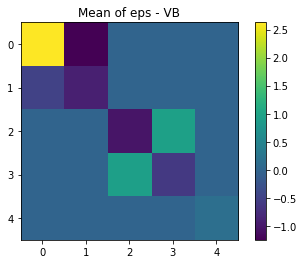

In [ ]:
plt.imshow(sess.run(tf_eps_means))
plt.colorbar()
plt.title('Mean of eps - VB')
plt.show()

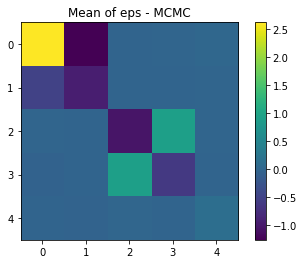

In [ ]:
plt.imshow(extract['eps'].mean(0))
plt.colorbar()
plt.title('Mean of eps - MCMC')
plt.show()

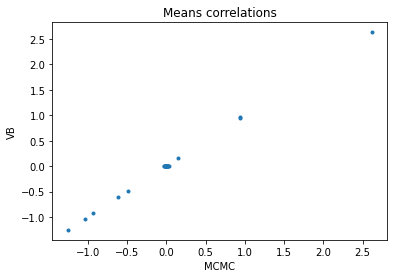

In [ ]:
plt.plot(extract['eps'].mean(0).flatten(),sess.run(tf_eps_means).flatten(),'.')
plt.xlabel('MCMC')
plt.ylabel('VB')
plt.title('Means correlations')
plt.show()

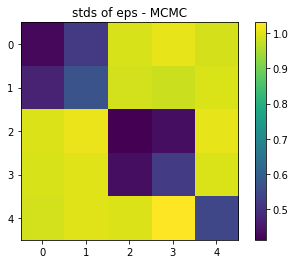

In [ ]:
plt.imshow(extract['eps'].std(0))
plt.colorbar()
plt.title('stds of eps - MCMC')
plt.show()

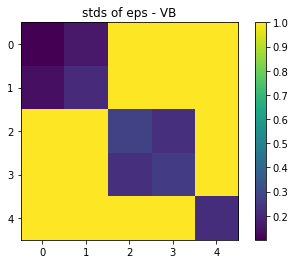

In [ ]:
plt.imshow(sess.run(tf_eps_stds))
plt.colorbar()
plt.title('stds of eps - VB')
plt.show()

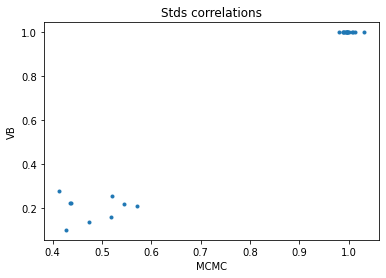

In [ ]:
plt.plot(extract['eps'].std(0).flatten(), sess.run(tf_eps_stds).flatten(),'.')
plt.xlabel('MCMC')
plt.ylabel('VB')
plt.title('Stds correlations')
plt.show()

In [ ]:
print('the offset estimated with VB is :', sess.run(tf_offset_mean)[0])
print('the offset estimated with MCMC is :', extract['offset'].mean(0))

the offset estimated with VB is : -5.0889535
the offset estimated with MCMC is : -5.072971040432845


The paper "blob a probabilistic model for recommendation that combines organic and bandit signals" extends this ideas.

Paper code : https://github.com/criteo-research/blob